In [5]:
import os
import numpy as np
import nibabel as nib
from scipy.ndimage import zoom
from sklearn.model_selection import train_test_split

# Step 0: Function to save NumPy arrays as .npy files
def save_as_npy(data, output_path):
    np.save(output_path, data)
    print(f"Data saved to: {output_path}")

# Step 1: Function to load NIfTI files
def load_nii_file(file_path):
    img = nib.load(file_path)
    return img.get_fdata()

# Step 2: Function to normalize CT image (clip Hounsfield units and scale to [0, 1])
def normalize_ct(ct_image, clip_min=-1000, clip_max=1000):
    ct_image = np.clip(ct_image, clip_min, clip_max) # Clip to Hounsfield range
    return (ct_image - clip_min) / (clip_max - clip_min) # Scale to [0, 1]

# Step 3: Function to normalize MRI image (scale to [0, 1])
def normalize_mri(mri_image, eps=1e-5):
    return (mri_image - np.min(mri_image)) / (np.max(mri_image) - np.min(mri_image) + eps)

# Step 4: Function to resize 2D images to target shape
def resize_image(image, target_shape):
    factors = (target_shape[0] / image.shape[0], target_shape[1] / image.shape[1])
    return zoom(image, factors, order=1)

# Step 5: Apply mask to MRI and CT slices
def apply_mask(mr_slice, ct_slice, mask_slice):
    masked_mr = np.where(mask_slice > 0, mr_slice, 0) # Keep only the masked area
    masked_ct = np.where(mask_slice > 0, ct_slice, 0) # Keep only the masked area
    return masked_mr, masked_ct

# Step 6: Process dataset
def process_dataset(base_dir, output_dir):
    train_input, train_output = [], []
    val_input, val_output = [], []
    test_input, test_output = [], []

    target_shape = (256, 256)

    # Collect folders for processing
    anatomy_dir = os.path.join(base_dir, "./Task1/brain")
    patient_folders = [os.path.join(anatomy_dir, folder) for folder in os.listdir(anatomy_dir) if os.path.isdir(os.path.join(anatomy_dir, folder))]

    # Split folders into learning (train+val) and test sets
    num_test_folders = max(1, round(0.1 * len(patient_folders))) # Approx. 10% for testing
    learning_folders, test_folders = train_test_split(patient_folders, test_size=num_test_folders, random_state=42)

    # Process test folders
    test_input_dir = os.path.join(output_dir, "Test_Patients_InputData")
    test_output_dir = os.path.join(output_dir, "Test_Patients_OutputData")
    os.makedirs(test_input_dir, exist_ok=True)
    os.makedirs(test_output_dir, exist_ok=True)

    for folder in test_folders:
        print("|", end="")
        mr_path = os.path.join(folder, "mr.nii.gz")
        ct_path = os.path.join(folder, "ct.nii.gz")
        mask_path = os.path.join(folder, "union_mask.nii.gz")

        if os.path.exists(mr_path) and os.path.exists(ct_path) and os.path.exists(mask_path):
            mr_img, ct_img, mask_img = load_nii_file(mr_path), load_nii_file(ct_path), load_nii_file(mask_path)
            num_slices = mr_img.shape[2]

            for slice_idx in range(num_slices):
                # Apply normalization
                mr_slice = normalize_mri(mr_img[:, :, slice_idx])
                ct_slice = normalize_ct(ct_img[:, :, slice_idx])
                mask_slice = normalize_mri(mask_img[:, :, slice_idx]) # Assuming mask image needs normalization as well

                # Apply mask
                masked_mr, masked_ct = apply_mask(mr_slice, ct_slice, mask_slice)

                # Resize
                masked_mr_resized = resize_image(masked_mr, target_shape)
                masked_ct_resized = resize_image(masked_ct, target_shape)

                test_input.append(masked_mr_resized)
                test_output.append(masked_ct_resized)

            # Save test data per folder
            patient_id = os.path.basename(folder)
            save_as_npy(np.array(test_input), os.path.join(test_input_dir, f"{patient_id}_input.npy"))
            save_as_npy(np.array(test_output), os.path.join(test_output_dir, f"{patient_id}_output.npy"))
            test_input, test_output = [], [] # Clear for next folder

    # Process learning folders (train + validation)
    input_data, output_data = [], []
    for folder in learning_folders:
        print(".", end="")
        mr_path = os.path.join(folder, "mr.nii.gz")
        ct_path = os.path.join(folder, "ct.nii.gz")
        mask_path = os.path.join(folder, "union_mask.nii.gz")

        if os.path.exists(mr_path) and os.path.exists(ct_path) and os.path.exists(mask_path):
            mr_img, ct_img, mask_img = load_nii_file(mr_path), load_nii_file(ct_path), load_nii_file(mask_path)
            num_slices = mr_img.shape[2]

            for slice_idx in range(num_slices):
                # Apply normalization
                mr_slice = normalize_mri(mr_img[:, :, slice_idx])
                ct_slice = normalize_ct(ct_img[:, :, slice_idx])
                mask_slice = normalize_mri(mask_img[:, :, slice_idx]) # Assuming mask image needs normalization as well

                # Apply mask
                masked_mr, masked_ct = apply_mask(mr_slice, ct_slice, mask_slice)

                # Resize
                masked_mr_resized = resize_image(masked_mr, target_shape)
                masked_ct_resized = resize_image(masked_ct, target_shape)

                input_data.append(masked_mr_resized)
                output_data.append(masked_ct_resized)

    # Split into train and validation sets
    train_input, val_input, train_output, val_output = train_test_split(
        input_data, output_data, test_size=0.1, random_state=42)

    # Save train and validation data
    save_as_npy(np.array(train_input), os.path.join(output_dir, "train_input.npy"))
    save_as_npy(np.array(train_output), os.path.join(output_dir, "train_output.npy"))
    save_as_npy(np.array(val_input), os.path.join(output_dir, "val_input.npy"))
    save_as_npy(np.array(val_output), os.path.join(output_dir, "val_output.npy"))

    print("\nProcessing completed.")
    print(f"Train set: {len(train_input)} pairs")
    print(f"Validation set: {len(val_input)} pairs")
    print(f"Test folders: {len(test_folders)} folders")

# Step 7: Execute processing
if __name__ == "__main__":
    base_dir = "./" # Replace with your dataset directory
    output_dir = os.path.join(base_dir, "data(brain)")
    os.makedirs(output_dir, exist_ok=True)

    process_dataset(base_dir, output_dir)

||||................................Data saved to: ./data(brain)\train_input.npy
Data saved to: ./data(brain)\train_output.npy
Data saved to: ./data(brain)\val_input.npy
Data saved to: ./data(brain)\val_output.npy

Processing completed.
Train set: 892 pairs
Validation set: 100 pairs
Test folders: 4 folders


Displaying output

In [9]:
import numpy as np
import random
import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import torchvision.transforms as T

# Load the .npy files
train_input = np.load('data(brain)/train_input.npy').astype(np.float32)  # Convert to float32
train_output = np.load('data(brain)/train_output.npy').astype(np.float32)  # Convert to float32
val_input = np.load('data(brain)/val_input.npy').astype(np.float32)
val_output = np.load('data(brain)/val_output.npy').astype(np.float32)
# test_input = np.load('data(Brain processed)/Test_Patients_InputData/1BA184_input.npy').astype(np.float32)
# test_output = np.load('data(Brain processed)/Test_Patients_OutputData/1BA184_output.npy').astype(np.float32)

# Custom transformation function for paired augmentation
class PairedTransform:
    def __init__(self):
        self.transforms = T.Compose([
            T.RandomHorizontalFlip(),
            T.RandomVerticalFlip(),
            T.RandomRotation(degrees=10),  # Random rotation within ±10 degrees
        ])
        self.normalize = T.Normalize(mean=[0.5], std=[0.5])  # Single-channel normalization

    def __call__(self, mri_image, ct_image):
        seed = random.randint(0, 2**32)  # Fix random seed for synchronized transformations
        torch.manual_seed(seed)
        mri_image = self.transforms(mri_image)
        torch.manual_seed(seed)
        ct_image = self.transforms(ct_image)

        # Normalize both images
        mri_image = self.normalize(mri_image)
        ct_image = self.normalize(ct_image)

        return mri_image, ct_image

# Custom Dataset Class
class MRICTDataset(Dataset):
    def __init__(self, input_data, output_data, transform=None):
        self.input_data = input_data
        self.output_data = output_data
        self.transform = transform

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, idx):
        # Load MRI and CT images
        mri_image = torch.tensor(self.input_data[idx][np.newaxis, :, :])  # Single channel
        ct_image = torch.tensor(self.output_data[idx][np.newaxis, :, :])  # Single channel

        if self.transform:
            mri_image, ct_image = self.transform(mri_image, ct_image)  # Paired transformation

        return mri_image, ct_image

# Initialize paired transformations
paired_transform = PairedTransform()

# Create Datasets and DataLoaders
train_dataset = MRICTDataset(train_input, train_output, transform=paired_transform)

(-0.5, 255.5, 255.5, -0.5)

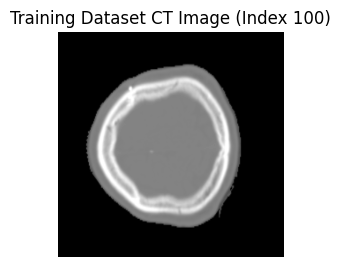

In [21]:
n=random.randint(0,100)
ct_image = train_dataset.output_data[n]

# CT image
plt.subplot(1, 2, 2)  # Side-by-side layout
plt.imshow(ct_image.squeeze(), cmap='gray')
plt.title(f'Training Dataset CT Image (Index {n})')
plt.axis('off')